In [1]:
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

In [2]:
print(f'Tensorflow {tf.__version__}')

Tensorflow 2.8.0


# Load dataset

In [9]:
# load dữ liệu
x_train = np.load('./data/X_train.npy')
y_train = np.load('./data/y_train.npy')

# chia data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)


# Image - Pre-processing

In [15]:
import random
# Thêm nhiễu vào ảnh
def add_noise(image, stddev = 50):
    noise = np.zeros(image.shape, np.uint8)
    cv2.randn(noise, np.random.randint(10, 100), stddev)
    
    noisy_img = cv2.add(image, noise)
    
    return noisy_img.flatten()

# Thay đổi ngẫu nhiên điểm ảnh
def random_swap_pixels(image):
    h, w = image.shape

    for _ in range(np.random.randint(10, 60)):
        # Chọn ngẫu nhiên hai điểm ảnh
        x1, y1 = np.random.randint(0, w - 1), np.random.randint(0, h - 1)
        x2, y2 = np.random.randint(0, w - 1), np.random.randint(0, h - 1)

        # Hoán đổi giá trị pixel của hai điểm ảnh
        image[y1, x1], image[y2, x2] = image[y2, x2], image[y1, x1]

    return image.flatten()

# Xoay ảnh
def random_rotate_vector(image):
    angle = np.random.randint(-180, 180)
    
    # Tạo ma trận
    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
    
    # Xoay bức ảnh
    rotated_img = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    return rotated_img.flatten()

# zoom ảnh
def random_zoom_vector(image, img_shape = [28, 28]):
    zoom_factor = np.random.uniform(0.5, 1.5)

    # Tạo ma trận biến đổi
    M = cv2.getRotationMatrix2D((img_shape[1] / 2, img_shape[0] / 2), 0, zoom_factor)
    
    # Thực hiện phóng to ảnh
    zoomed_image = cv2.warpAffine(image, M, (img_shape[1], img_shape[0]))


    return zoomed_image.flatten()

def random_flip(image):
    if np.random.rand() < 0.5:
        flipped_image = cv2.flip(image, 1)
        return flipped_image.flatten()
    else:
        flipped_image = cv2.flip(image, 0)
        return flipped_image.flatten()

def convolution_image(image):
    # Highpass Kernel: finds edges
    kernel = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])
    
    return cv2.filter2D(image, -1, kernel).flatten()
    
# create data augmentation
def create_pretrain_data(dataset, n, img_shape = (28, 28)):
    data1 = [add_noise(image.reshape(img_shape)) for image in np.tile(dataset, (n, 1))]
    data2 = [random_flip(image.reshape(img_shape)) for image in np.tile(dataset, (n, 1))]
    data3 = [random_zoom_vector(image.reshape(img_shape)) for image in np.tile(dataset, (n, 1))]
    data4 = [random_swap_pixels(image.reshape(img_shape)) for image in np.tile(dataset, (n, 1))]
    data5 = [random_rotate_vector(image.reshape(img_shape)) for image in np.tile(dataset, (n, 1))]
    data6 = [random_flip(image.reshape(img_shape)) for image in np.tile(dataset, (n, 1))]

    data = data1 + data2 + data3 + data4 + data5 + data6
    
    return np.array(data)

In [16]:
# Tạo dữ liệu để pretraining
n = 2
x_pretrain = create_pretrain_data(x_train, n)
y_pretrain = np.tile(y_train, n*6)

In [17]:
from tensorflow.keras.utils import to_categorical
# chuyển label thành 1 vector one hot
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_pretrain = to_categorical(y_pretrain)

In [18]:
print(x_pretrain.shape)
print(y_pretrain.shape)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(403200, 784)
(403200, 10)
(33600, 784)
(33600, 10)
(8400, 784)
(8400, 10)


# Multilayer Perceptron (MLP) Architecture

- ## Pretraining

In [19]:
def create_pretrain_model():
    input_image = layers.Input(shape=(784, ))

    data_augmentation = keras.Sequential(
        [
            layers.Normalization(),
            layers.Reshape((28, 28, 1)),
        ],
        name="data_augmentation",
    )
    
    augmented = data_augmentation(input_image)
    
    # Chia hình ảnh thành các patches
    patch_size = (4, 4)
    patches = tf.image.extract_patches(augmented, sizes=[1, patch_size[0], patch_size[1], 1], strides=[1, 1, 1, 1], rates=[1, 1, 1, 1], padding='SAME')

    # Xây dựng mô hình MLP cho việc trích xuất đặc trưng từ mỗi patch
    patch_model = keras.Sequential([
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu')
    ])

    # Trích xuất đặc trưng từ mỗi patch
    patch_features = patch_model(patches)
    
    x = layers.Dense(512, activation='relu') (patch_features)
    x = layers.BatchNormalization() (x)
    x = layers.Dense(256, activation='relu') (x)
    x = layers.Dropout(0.1) (x)
    x = layers.BatchNormalization() (x)
    x = layers.Dense(128, activation='relu') (x)
    x = layers.Dropout(0.1) (x)
    x = layers.BatchNormalization() (x)
    x = layers.Dense(10, activation='softmax') (x)
    
    model = keras.Model(inputs=input_image, outputs=x)

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='Adam', metrics=['accuracy'])

    return model

In [20]:
pretraining_model = create_pretrain_model()
pretraining_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 data_augmentation (Sequenti  (None, 28, 28, 1)        1569      
 al)                                                             
                                                                 
 tf.image.extract_patches (T  (None, 28, 28, 16)       0         
 FOpLambda)                                                      
                                                                 
 sequential (Sequential)     (None, 128)               6590336   
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048  

In [21]:
# train dữ liệu pretrain
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-12)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
callback = tf.keras.callbacks.ModelCheckpoint(filepath = './weights/pretrain_model/model.{epoch}-{val_loss:.4f}', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False)

pre_train_his = pretraining_model.fit(x_pretrain, y_pretrain, epochs=100, batch_size=256, validation_split=0.2, callbacks=[callback, reduce_lr, early_stopping], shuffle=True)

Epoch 1/100
1260/1260 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.7477
Epoch 1: saving model to ./weights/pretrain_model\model.1-0.5802
INFO:tensorflow:Assets written to: ./weights/pretrain_model\model.1-0.5802\assets
1260/1260 [==============================] - 103s 81ms/step - loss: 0.6851 - accuracy: 0.7477 - val_loss: 0.5802 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 2/100
1260/1260 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.8067
Epoch 2: saving model to ./weights/pretrain_model\model.2-0.5689
INFO:tensorflow:Assets written to: ./weights/pretrain_model\model.2-0.5689\assets
1260/1260 [==============================] - 111s 88ms/step - loss: 0.5225 - accuracy: 0.8067 - val_loss: 0.5689 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 3/100
1260/1260 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.8258
Epoch 3: saving model to ./weights/pretrain_model\model.3-0.5115
INFO:tensorflow:Assets written to: ./weights/p

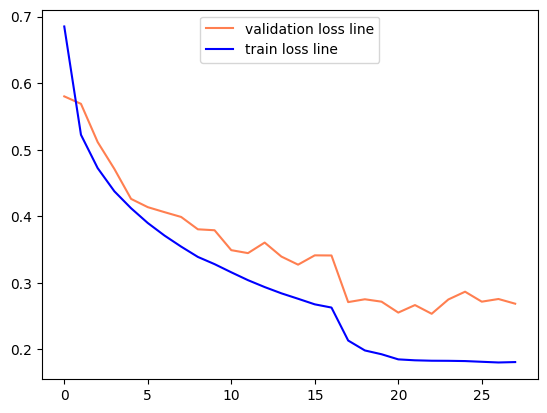

In [22]:
plt.plot(pre_train_his.history['val_loss'], c = 'coral', label = "validation loss line")
plt.plot(pre_train_his.history['loss'], c = 'blue', label = 'train loss line')
legend = plt.legend(loc='upper center')
plt.show()

In [40]:
# load pretrain model
pretraining_model = tf.keras.models.load_model('./weights/pretrain_model/model.23-0.2536')

- # Train predict model

In [42]:
from tensorflow.keras.models import clone_model
# Xây dựng mô hình
def create_model():
    # x = layers.Dense(64, activation='relu') (pretraining_model.layers[-2].output)
    # x = layers.Dropout(0.1) (x)
    # x = layers.BatchNormalization() (x)
    x = layers.Dense(10, activation='softmax') (pretraining_model.layers[-2].output)
    
    predict_model = keras.Model(inputs=pretraining_model.input, outputs=x)
    
    predict_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='Adam', metrics=['accuracy'])
    
    return predict_model

In [43]:
predict_model = create_model()
predict_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 data_augmentation (Sequenti  (None, 28, 28, 1)        1569      
 al)                                                             
                                                                 
 tf.image.extract_patches (T  (None, 28, 28, 16)       0         
 FOpLambda)                                                      
                                                                 
 sequential (Sequential)     (None, 128)               6590336   
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048

In [44]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1.0000e-12)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
callback = tf.keras.callbacks.ModelCheckpoint(filepath = './weights/predict_model/model.{epoch}-{val_loss:.4f}', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False)

# bắt đầu training
his = predict_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = 100, batch_size = 256, shuffle=True, callbacks=[early_stopping, reduce_lr, callback])

Epoch 1/100
131/132 [============================>.] - ETA: 0s - loss: 0.3878 - accuracy: 0.8864
Epoch 1: saving model to ./weights/predict_model\model.1-0.3485
INFO:tensorflow:Assets written to: ./weights/predict_model\model.1-0.3485\assets
132/132 [==============================] - 14s 95ms/step - loss: 0.3876 - accuracy: 0.8864 - val_loss: 0.3485 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 2/100
131/132 [============================>.] - ETA: 0s - loss: 0.1561 - accuracy: 0.9462
Epoch 2: saving model to ./weights/predict_model\model.2-0.3486
INFO:tensorflow:Assets written to: ./weights/predict_model\model.2-0.3486\assets
132/132 [==============================] - 12s 93ms/step - loss: 0.1560 - accuracy: 0.9462 - val_loss: 0.3486 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9501
Epoch 3: saving model to ./weights/predict_model\model.3-0.3562
INFO:tensorflow:Assets written to: ./weights/predict_model\mode

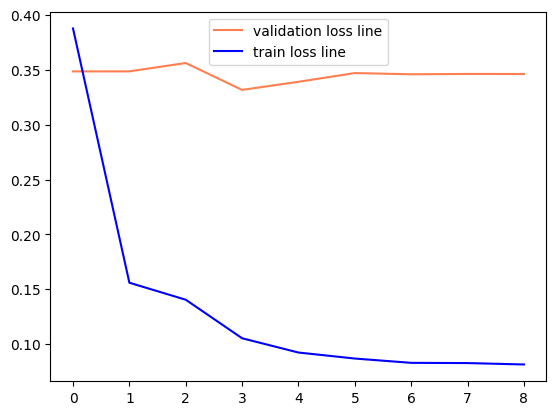

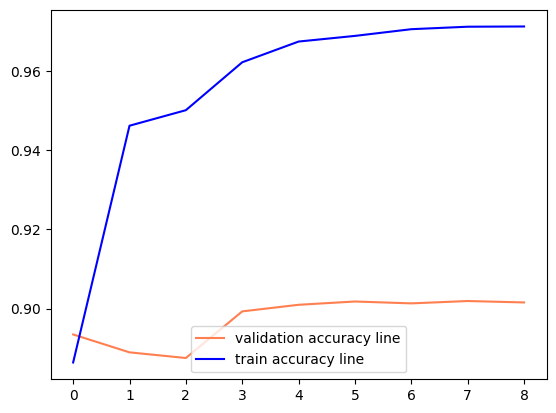

In [45]:
# vẽ đường loss trên tập train và tập validation
plt.plot(his.history['val_loss'], c = 'coral', label = "validation loss line")
plt.plot(his.history['loss'], c = 'blue', label = 'train loss line')
legend = plt.legend(loc='upper center')
plt.show()

# vẽ đường accuracy trên tập train và tập validation
plt.plot(his.history['val_accuracy'], c = 'coral', label = 'validation accuracy line')
plt.plot(his.history['accuracy'], c = 'blue', label = 'train accuracy line')
legend = plt.legend(loc='lower center')
plt.show()

In [46]:
# load predict model
predict_model = tf.keras.models.load_model('./weights/predict_model/model.8-0.3462')

In [47]:
# dự đoán kết quả sau đó xuất ra csv
x_test = np.load('./data/X_test.npy')
predictions = predict_model.predict(x_test)
predicted_labels = predictions.argmax(axis=1)
results = pd.DataFrame({
    'index': range(len(x_test)),
    'label': predicted_labels
})
results.to_csv('Latest_submission.csv', index=False)